Made by [Zhenhao Li](mailto:zhenhao.li18@imperial.ac.uk), and [Nihir](mailto:nv419@ic.ac.uk).

[The AI Core](https://theaicore.com)

# Contents
- [Last week recap](#Last-week-recap)
- [Bi-directional RNNs](#BiDirectional-RNNs)
- [Sequence to sequence model](#Sequence-to-sequence-model)
 - [BLEU Score](#BLEU-Score)
- [Attention](#Attention)
- [Sequence to sequence with Attention](#Seq2seq-with-Attention)
- [Transformer](#Transformer)

# Last week recap:

![rnn_classification](images_lecture2/rnn_classification.png)
![rnn_lm](images_lecture2/rnn_lm.png)


In [1]:
# import essential libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
import math
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# BiDirectional RNNs

In problems where all timesteps of the input sequence are available, bidirectional RNNs train two instead of one RNNs on the input sequence. The first on the input sequence as-is and the second on a reversed copy of the input sequence. Outputs at the same step are then usually concatenated. This can provide additional useful context to the model.

Q: Why is a bi-directional RNN is better than single-direction ?

Imagine that you see only the left context: "We went to ..." This context is very general and a lot of different words can continue: nouns (London, work, cinema, doctor), verbs (join, support), etc. When we both left and right contexts the word "sleep" is becoming evident: "We went to ... early but still could not wake up on time."


![bi_rnn_classification](images_lecture2/bi_rnn_classification.png)

![](images_lecture2/bi_rnn.png)

# Sequence-to-sequence model

https://arxiv.org/abs/1409.3215 \
So far we have encountered some classification tasks where the inputs are of variable length. We use Recurrent Neural Networks (RNN/LSTM/GRU) to do predictions. However, when it comes to text generation, the length of outputs might also be random. In this case, we use a sequence-to-sequence model. \
![](images_lecture2/seq2seq.png)

A sequence-to-sequence (seq2seq) model is a model that consists of two components called **Encoder** and **Decoder**. Commonly, two recurrent neural networks are used as the encoder and the decoder. The input is fed into the encoder RNN token by token, producing a fix-lengthed vector (the final hidden state) that encodes the context of all input sequence. We refer to this vector as the **context vector**. The decoder uses this context vector as the initialization of its first hidden state and inits the input with the $<sos>$ token, generating the outputs token by token.

Seq2seq model is often used in NLP tasks where the lengths of both input and output are not fixed, e.g. machine translation, dialogue system. In the following part, we are going to build a vanilla seq2seq model with LSTM as encoder/decoder module on the machine translation task.

https://pytorch.org/tutorials/beginner/torchtext_translation_tutorial.html \
https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation-batched.ipynb


# Model
### Encoder
We have three layers in the encoder: an embedding layer (with dropout), a RNN layer, and a linear layer. As we have known from the word representation session, we can apply a embedding layer and distributed word representation is trained jointly with the model. 

If we want to have a bidirectional encoder to encode both forward and backward contexts in the input, the hidden dimension of the RNN layer is doubled. Therefore, the linear layer is here to keep the same dimensionality between the encoder output and decoder input.

In [2]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, layers, PAD_IDX=1, bidirectional=False, dropout=0.1):
        super(Encoder, self).__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.layers = layers
        self.bidirectional = bidirectional
        self.PAD_IDX = PAD_IDX
        
        
        # If we use a bidirectional encoder to encode both forward and backward context,
        # the dimension of the hidden state will double
        self.dropout = nn.Dropout(dropout)
        if bidirectional:
            ff_input_dim = 2 * hidden_dim
        else:
            ff_input_dim = hidden_dim
        
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=PAD_IDX)
        self.rnn = nn.LSTM(emb_dim, self.hidden_dim, layers, dropout=dropout, \
                           bidirectional=bidirectional, bias=False, batch_first=True)
        self.ff = nn.Sequential(
            nn.Linear(ff_input_dim, hidden_dim),
            nn.Tanh()
        )
        
    # x: (T, B)
    def forward(self, x):
        # x: (B, T)
        x = x.permute(1, 0)
        
        # x: (B, T, E)
        x = self.dropout(self.embedding(x))

        # outputs: (B, T, H*directions)
        # h_n: (layers*directions, B, H)
        outputs, (h_n, c_n) = self.rnn(x)
        

        if self.bidirectional:
            # concatenate the forward and backward hidden states
            h_n = torch.cat((h_n[0::2,:,:], h_n[1::2,:,:]), dim = -1)
            c_n = torch.cat((c_n[0::2,:,:], c_n[1::2,:,:]), dim = -1)
        
        # h_n: (layers, B, H)
        # c_n: (layers, B, H)
        h_n = self.ff(h_n)
        c_n = self.ff(c_n)
        
        # outputs: ()
        return outputs, (h_n, c_n)
        

### Decoder
The decoder has four layers: an embedding layer (with dropout), a unidirectional RNN layer and two linear layers. The decoder is always unidirectional in that we only generate the outputs from left to right. 

In [3]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, layers, PAD_IDX=1, dropout=0.1):
        super(Decoder, self).__init__()
        self.output_dim = output_dim
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.layers = layers
        
        self.dropout = nn.Dropout(dropout)
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=PAD_IDX)
        self.rnn = nn.LSTM(emb_dim, hidden_dim, layers, dropout=dropout, batch_first=True) # we don't set bidirectional here
        
        self.ff = nn.Sequential(
            nn.Linear(hidden_dim, emb_dim),
            nn.Tanh()
        )
        # This linear layer is to ensure the output layer has the same dimensionality with the embedding layer
        self.out = nn.Linear(emb_dim, output_dim)
        
    # x: (B)
    def forward(self, x, hidden):
        # we expand the dim of sequence length
        # x: (B, 1)
        x = x.unsqueeze(1)
        
        # embed: (B, 1, E)
        embed = self.dropout(self.embedding(x))

        
        # output: (B, 1, H)
        # h_n: (layers, B, H)
        output, hidden = self.rnn(embed, hidden)
        
        # output: (B, 1, E)
        output = self.ff(output)
        
        # output: (B, output_dim)
        output = self.out(output).squeeze(1)
        return output, hidden

###### Teacher forcing
Teacher forcing is used in training to reduce error propagation and accelerate training. During training, the next input to the decoder can be either the ground truth token or the output by the decoder, determined by a *teacher_force_ratio*.

In [4]:
class Seq2seq(nn.Module):
    
    def __init__(self, encoder, decoder, device='cpu', with_attn=False):
        super(Seq2seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.with_attn = with_attn
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[1]
        max_len = trg.shape[0]
        output_dim = self.decoder.output_dim
        
        outputs = torch.zeros(max_len, batch_size, output_dim).to(self.device)
        
        enc_outputs, hidden = self.encoder(src)
        
        # initialize output sequence with '<sos>'
        dec_output = trg[0,:]
        print("DEC_OUTPUT", dec_output.shape)
        
        # decoder token by token
        for t in range(1, max_len):
            if self.with_attn:
                dec_output, hidden, _ = self.decoder(dec_output, hidden, enc_outputs)
            else:
                dec_output, hidden = self.decoder(dec_output, hidden)
                print("DEC_OUTPUT RNN", dec_output.shape)
                
            outputs[t] = dec_output
            teacher_force = random.random() < teacher_forcing_ratio
            
            pred_next = dec_output.argmax(1)
            
            dec_output = (trg[t] if teacher_force else pred_next)
        return outputs

    # greedy search for actual translation
    def greedy_search(self, src, sos_idx, max_len=50, return_attention=False):
        src = src.to(self.device)
        batch_size = src.shape[1]
        src_len = src.shape[0]
        
        outputs = torch.zeros(max_len, batch_size).to(self.device)
        
        enc_outputs, hidden = self.encoder(src)
        
        
        dec_output = torch.zeros(batch_size, dtype=torch.int64).to(device)
        dec_output.fill_(sos_idx)
        
        outputs[0] = dec_output
        
        attentions = torch.zeros(max_len, batch_size, src_len).to(self.device)
        
        for t in range(1, max_len):
            if self.with_attn:
                dec_output, hidden, attention_score = self.decoder(dec_output, hidden, enc_outputs)
                attentions[t] = attention_score
            else:
                dec_output, hidden = self.decoder(dec_output, hidden)
            
            dec_output = dec_output.argmax(1)

            outputs[t] = dec_output
            
        if return_attention:
            return outputs, attentions
        else:
            return outputs

Now we have finished our seq2seq model, let's build a toy model.

In [5]:
INPUT_DIM=4
OUTPUT_DIM=4
EMB_DIM=10
HIDDEN_DIM=6
LAYERS=2

# define the encoder and decoder, and build the model
enc = Encoder(INPUT_DIM, EMB_DIM, HIDDEN_DIM, LAYERS)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HIDDEN_DIM, LAYERS)
model = Seq2seq(enc, dec)
print(model)

Seq2seq(
  (encoder): Encoder(
    (dropout): Dropout(p=0.1, inplace=False)
    (embedding): Embedding(4, 10, padding_idx=1)
    (rnn): LSTM(10, 6, num_layers=2, bias=False, batch_first=True, dropout=0.1)
    (ff): Sequential(
      (0): Linear(in_features=6, out_features=6, bias=True)
      (1): Tanh()
    )
  )
  (decoder): Decoder(
    (dropout): Dropout(p=0.1, inplace=False)
    (embedding): Embedding(4, 10, padding_idx=1)
    (rnn): LSTM(10, 6, num_layers=2, batch_first=True, dropout=0.1)
    (ff): Sequential(
      (0): Linear(in_features=6, out_features=10, bias=True)
      (1): Tanh()
    )
    (out): Linear(in_features=10, out_features=4, bias=True)
  )
)


# Data Loading with Torchtext
https://pytorch.org/text/ \
Now we are running a machine translation model on actual dataset: Multi30k. Multi30k is a dataset for multi-modal machine translation. We'll only use the texts in this dataset and we load the dataset with *Torchtext*, which can help us with all the pre-processing and data loading.

In [6]:
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

# torchtext will pre-process the data, including tokenization, padding, stoi, etc.
SRC = Field(tokenize = "spacy",
            tokenizer_language="de",
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

TRG = Field(tokenize = "spacy",
            tokenizer_language="en",
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'),
                                                    fields = (SRC, TRG))
# print the number of examples in train/valid/test sets
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


In [7]:
# build a vocab of our training set, ignoring word with frequency less than 2
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [8]:
# build train/valid/test iterators, which will batch the data for us
BATCH_SIZE = 128
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device)

x = vars(test_data.examples[0])['src']
y = vars(test_data.examples[0])['trg']
print("Source example:", " ".join(x))
print("Target example:", " ".join(y))
print("Padded target:", TRG.pad([y]))
print("Tensorized target:", TRG.process([y]))

Source example: ein mann mit einem orangefarbenen hut , der etwas anstarrt .
Target example: a man in an orange hat starring at something .
Padded target: [['<sos>', 'a', 'man', 'in', 'an', 'orange', 'hat', 'starring', 'at', 'something', '.', '<eos>']]
Tensorized target: tensor([[   2],
        [   4],
        [   9],
        [   6],
        [  21],
        [  86],
        [  67],
        [2599],
        [  20],
        [ 121],
        [   5],
        [   3]])


# Model, optimizer and criterion
This is our model hyperparameters. In actual training, we might need to tune the hyperparameters on the validation set before evaluating on the test set.

In [9]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
EMB_DIM=256
HIDDEN_DIM=512
LAYERS=1
DROPOUT=0.5
BIDIRECTIONAL=True

In [10]:
# padding token
SRC_PAD = SRC.vocab.stoi['<pad>']
TRG_PAD = TRG.vocab.stoi['<pad>']

# build model
enc = Encoder(INPUT_DIM, EMB_DIM, HIDDEN_DIM, LAYERS, PAD_IDX=SRC_PAD, bidirectional=BIDIRECTIONAL, dropout=DROPOUT)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HIDDEN_DIM, LAYERS, PAD_IDX=TRG_PAD, dropout=DROPOUT)
model = Seq2seq(enc, dec, device).to(device)

C:\Python\Python37\lib\site-packages\torch\nn\modules\rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Weight initialization sometimes boost training and the model can converge faster. We initialize the model parameters using a uniform distribution.

In [11]:
# initialize weights
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.1, 0.1)
        
model.apply(init_weights)
print(model)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

Seq2seq(
  (encoder): Encoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(7855, 256, padding_idx=1)
    (rnn): LSTM(256, 512, bias=False, batch_first=True, dropout=0.5, bidirectional=True)
    (ff): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): Tanh()
    )
  )
  (decoder): Decoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(5893, 256, padding_idx=1)
    (rnn): LSTM(256, 512, batch_first=True, dropout=0.5)
    (ff): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): Tanh()
    )
    (out): Linear(in_features=256, out_features=5893, bias=True)
  )
)
The model has 10,412,805 trainable parameters


Optimizer will update the gradient everytime we back-propagate. We are using Adam as our optimizer.

In [12]:
LR=0.001
# set optimizer and learning rate
optimizer = optim.Adam(model.parameters(), lr=LR)

We use *CrossEntropyLoss* as our loss function, which will calculate the log softmax and the negative log-likelihood. We pass the padding token in the target vocab to the criterion so that it will ignore the loss for this token.

In [13]:
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD)

Now we can define our training loop.
1. We iterate over the training iterator and get a batch of training examples
2. The input is passed through the model and it returns the predictions
3. We calculate the loss between the model predictions and the ground truths
4. We back-propagate the loss and the optimizer will update the gradients

To avoid exploding gradient, we clip the gradients to a maximum value every training iteration

In [ ]:
writer = SummaryWriter('runs/seq2seq')

In [14]:
def train(model, iterator, optimizer, criterion, grad_clip, num_epoch):
    model.train()
    
    total_loss = 0

    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()
        
        outputs = model(src, trg)
        
        # exclude <sos> token
        # outputs: (seq_len * batch_size, output_dim)
        # trg : (seq_len * batch_size)
        outputs = outputs[1:].view(-1, outputs.shape[-1])
        trg = trg[1:].view(-1)

        loss = criterion(outputs, trg)
        
        writer.add_scalar('training loss',
                            loss.item(),
                            num_epoch * len(iterator) + i)
        
        if i % 50 == 0:
            print('Batch:\t {0} / {1},\t loss: {2:2.3f}'.format(i, len(iterator), loss.item()))
        
        loss.backward()
        # clip grad to avoid gradient explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        
        total_loss += loss.item()
    return total_loss / len(iterator)

The evaluating loop is similar to the training loop, except that we don't want to do back-propagation.

In [16]:
def eval(model, iterator, criterion):
    # In eval model, layers such as Dropout, BatchNorm will work in eval model
    model.eval()
    
    total_loss = 0
    # this prevents the back-propagation
    with torch.no_grad():
        for _, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg
            
            # during test time, we have no correct trg so we turn off teacher forcing
            outputs = model(src, trg, teacher_forcing_ratio=0)
            
            outputs = outputs[1:].view(-1, outputs.shape[-1])
            trg = trg[1:].view(-1)

            loss = criterion(outputs, trg)
            total_loss += loss.item()
    return total_loss / len(iterator)

## BLEU

![](images_lecture2/bleu1.png)
![](images_lecture2/bleu2.png)

In [17]:
# Helper function, converting a batch of tensors to the text form
def get_text_from_tensor(tensor, field, eos='<eos>'):
    batch_output = []
    for i in range(tensor.shape[1]):
        sequence = tensor[:,i]
        words = []
        for tok_idx in sequence:
            tok_idx = int(tok_idx)
            token = field.vocab.itos[tok_idx]

            if token == '<sos>':
                continue
            elif token == '<eos>' or token == '<pad>':
                break
            else:
                words.append(token)
        words = " ".join(words)
        batch_output.append(words)
    return batch_output

In [18]:
import sacrebleu

def test_bleu(model, iterator, trg_field, with_attention=False):
    model.eval()

    ref = []
    hyp = []
    
    with torch.no_grad():
        for _, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg
            
            outputs = model.greedy_search(src, trg_field.vocab.stoi['<sos>'], return_attention=with_attention)
            
            hyp += get_text_from_tensor(outputs, trg_field)
            ref += get_text_from_tensor(trg, trg_field)
            
    # expand dim of reference list
    # sys = ['translation_1', 'translation_2']
    # ref = [['truth_1', 'truth_2'], ['another truth_1', 'another truth_2']]
    ref = [ref]
    return sacrebleu.corpus_bleu(hyp, ref, force=True).score

Now let's start our training! We keep the checkpoint with the highest valid BLEU as our best checkpoint.

**The training is heavily dependent on GPU, so it might take years to train on CPU. You may skip this block and load our pre-trained model.**

In [19]:
EPOCH = 30
CLIP = 1

best_bleu = 0

for i in range(EPOCH):
    print('Start training Epoch {}:'.format(i+1))
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, i)
    valid_loss = eval(model, valid_iterator, criterion)
    bleu = test_bleu(model, valid_iterator, TRG)
    
    writer.add_scalar('valid loss',
                valid_loss,
                i)
    writer.add_scalar('valid ppl',
                      math.exp(valid_loss),
                     i)
    writer.add_scalar('valid BLEU',
                bleu.score,
                i)
    
    if bleu.score > best_bleu:
        best_bleu = bleu.score
        torch.save(model.state_dict(), 'checkpoint_best-seq2seq.pt')
    
    print('Epoch {0} train loss: {1:.3f} | Train PPL: {2:7.3f}'.format(i+1, train_loss, math.exp(train_loss)))
    print('Epoch {0} valid loss: {1:.3f} | Valid PPL: {2:7.3f}'.format(i+1, valid_loss, math.exp(valid_loss)))
    print('Epoch {0} valid BLEU: {1:3.3f}'.format(i+1, bleu.score))

Start training Epoch 1:
DEC_OUTPUT torch.Size([128])
DEC_OUTPUT RNN torch.Size([128, 5893])
DEC_OUTPUT RNN torch.Size([128, 5893])
DEC_OUTPUT RNN torch.Size([128, 5893])
DEC_OUTPUT RNN torch.Size([128, 5893])
DEC_OUTPUT RNN torch.Size([128, 5893])
DEC_OUTPUT RNN torch.Size([128, 5893])
DEC_OUTPUT RNN torch.Size([128, 5893])
DEC_OUTPUT RNN torch.Size([128, 5893])
DEC_OUTPUT RNN torch.Size([128, 5893])
DEC_OUTPUT RNN torch.Size([128, 5893])
DEC_OUTPUT RNN torch.Size([128, 5893])
DEC_OUTPUT RNN torch.Size([128, 5893])
DEC_OUTPUT RNN torch.Size([128, 5893])
DEC_OUTPUT RNN torch.Size([128, 5893])
DEC_OUTPUT RNN torch.Size([128, 5893])
DEC_OUTPUT RNN torch.Size([128, 5893])
DEC_OUTPUT RNN torch.Size([128, 5893])
DEC_OUTPUT RNN torch.Size([128, 5893])
DEC_OUTPUT RNN torch.Size([128, 5893])
DEC_OUTPUT RNN torch.Size([128, 5893])
DEC_OUTPUT RNN torch.Size([128, 5893])
DEC_OUTPUT RNN torch.Size([128, 5893])
DEC_OUTPUT RNN torch.Size([128, 5893])
DEC_OUTPUT RNN torch.Size([128, 5893])
DEC_OUTPUT 

NameError: name 'writer' is not defined

## Evaluation on test set
Finally we can evaluate our best model on the test set.
Let's load the pre-trained model and calculate the bleu score on the test data.

In [ ]:
model.load_state_dict(torch.load('checkpoint_best-seq2seq.pt', map_location=torch.device(device)))
print(test_bleu(model, test_iterator, TRG))

# Translate
Now we can translate an actual German sentence into English.

In [ ]:
def get_eos_position(tensor, field):
    for position, tok_idx in enumerate(tensor):
        tok_idx = int(tok_idx)
        token = field.vocab.itos[tok_idx]
        
        if token == '<eos>' or token == '<pad>':
            break
    return position

In [ ]:
def translate(model, text, src_field, tgt_field):
    tokens = src_field.preprocess(text)
    input_tensor = src_field.process([tokens])
    
    outputs = model.greedy_search(input_tensor, tgt_field.vocab.stoi['<sos>'])
    
    output_text = get_text_from_tensor(outputs, tgt_field)
    return output_text

In [ ]:
translate(model, 'ein mann mit einem orangefarbenen hut, der etwas anstarrt.', SRC, TRG)

# The problem with simple Seq2seq model
The seq2seq model we learned compress the whole input sentence into a fixed-length vector. However, there might be a problem when the input sequence become very long. It is hard to compress all necessary information in this fixed-length context vector, and the final hidden states tend to include recent words information and forget words with long distance. 

Rather than using a single context vector, we can use all the encoder hidden states, and now we are introducing the attention mechanism.

# Attention
https://arxiv.org/pdf/1409.0473.pdf
https://arxiv.org/pdf/1508.04025.pdf
The attention mechanism allows the decoder to search the source sentence and concentrate on the more relevant information (based on previous decoder hidden state), at each decoding step. \
At decoding step $t$, a context vector $c_i$ is computed as a weighted sum of all encoder hidden states.
$$ c_i = \sum^T_t\alpha_{i,t}h_t$$
The weight $\alpha_{i,t}$ represent the relatedness of source token at position $t$ when the decoder is generating the target token $i$.
Then we need to calculate the relatedness by a certain function (alignment function). $$e_{i,t}=a(s_{i-1}, h_t)$$
To have the weights summing up to 1, we can apply a softmax over $e$, and we can have $$\alpha_{i,t}=\frac{exp(e_{i,t})}{\sum_{k=1}^Texp(e_{i,k})}$$
### Alignment function
The alignment function can be of various types. In the original attention paper, a MLP is used: $$a(s_{i-1}, h_t) = v_a^Ttanh(W_as_{i-1}+U_ah_t)$$

![](https://insidebigdata.com/wp-content/uploads/2018/09/Eleks_3.png)
![](images/seq2seq_attention.png)
![](images/attention_module.png)

# Seq2seq with Attention
In the following parts, we are going to implement a sequence-to-sequence model with the attention mechanism and compare it with the previous seq2seq model.

In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        
        self.W = nn.Linear(3*hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    # dec_hidden： （1, B, H)
    # enc_outputs: (B, T, 2H)
    def forward(self, dec_hidden, enc_outputs):
        batch_size = dec_hidden.shape[1]
        src_len = enc_outputs.shape[1]
        
        # dec_hidden: (B, 1, H)
        dec_hidden = dec_hidden.permute(1, 0, 2)
        # dec_hidden: (B, T, H)
        dec_hidden = dec_hidden.repeat(1, src_len, 1)
        
        # energy: (B, T, H)
        energy = torch.tanh(self.W(torch.cat((dec_hidden, enc_outputs), dim=2)))
        
        # attention: (B, T)
        attention = F.softmax(self.v(energy).squeeze(2), dim=1)
        
        return attention

In [ ]:
class AttnDecoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, PAD_IDX=1, dropout=0.1):
        super(AttnDecoder, self).__init__()
        
        self.output_dim = output_dim
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        
        self.dropout = nn.Dropout(dropout)
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=PAD_IDX)
        self.attention = Attention(hidden_dim)
        self.rnn = nn.LSTM(emb_dim+2*hidden_dim, hidden_dim, dropout=dropout, batch_first=True) 
        
        self.ff = nn.Sequential(
            nn.Linear(3*hidden_dim + emb_dim, emb_dim),
            nn.Tanh()
        )
        
        # This linear layer is to ensure the output layer has the same dimensionality with the embedding layer
        self.out = nn.Linear(emb_dim, output_dim)
        
    
    # x: (B)
    # hidden=(h_n, c_n): (1, B, H)
    # enc_outputs=(B, T, 2H)
    def forward(self, x, hidden, enc_outputs):
        # we expand the dim of sequence length
        # x: (B, 1)
        x = x.unsqueeze(1)
        
        # embed: (B, 1, E)
        embed = self.dropout(self.embedding(x))
        
        # attn_score: (B, 1, T)
        attn_score = self.attention(hidden[0], enc_outputs).unsqueeze(1)
        
        # c: (B, 1, 2H)
        c = torch.bmm(attn_score, enc_outputs)
        
        # output: (B, 1, H)
        # h_n: (1, B, H)
        output, hidden = self.rnn(torch.cat((embed, c), dim=2), hidden)
        
        # output: (B, 1, E)
        output = self.ff(torch.cat((output, c, embed), dim=2))
        
        # output: (B, output_dim)
        output = self.out(output).squeeze(1)
        return output, hidden, attn_score.squeeze(1)

### Hyperparameters
We use the same hyperparameters for the attention-based model, but we need to reset the optimizer and criterion.

In [ ]:
# padding token
SRC_PAD = SRC.vocab.stoi['<pad>']
TRG_PAD = TRG.vocab.stoi['<pad>']

# build model
enc = Encoder(INPUT_DIM, EMB_DIM, HIDDEN_DIM, LAYERS, PAD_IDX=SRC_PAD, bidirectional=BIDIRECTIONAL, dropout=DROPOUT)
dec = AttnDecoder(OUTPUT_DIM, EMB_DIM, HIDDEN_DIM, PAD_IDX=TRG_PAD, dropout=DROPOUT)
model = Seq2seq(enc, dec, device, with_attn=True).to(device)

# initialize weights
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.1, 0.1)
        
model.apply(init_weights)
print(model)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

LR=0.001
# set optimizer and learning rate
optimizer = optim.Adam(model.parameters(), lr=LR)

criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD)

In [ ]:
EPOCH = 20
CLIP = 1

best_bleu = 0
writer = SummaryWriter('runs/seq2seq-attn')

for i in range(EPOCH):
    print('Start training Epoch {}:'.format(i+1))
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, i)
    valid_loss = eval(model, valid_iterator, criterion)
    bleu = test_bleu(model, valid_iterator, TRG)
    
    writer.add_scalar('valid loss',
                valid_loss,
                i)
    writer.add_scalar('valid ppl',
                      math.exp(valid_loss),
                     i)
    writer.add_scalar('valid BLEU',
                bleu.score,
                i)
    
    if bleu.score > best_bleu:
        best_bleu = bleu.score
        torch.save(model.state_dict(), 'checkpoint_best-seq2seq-attn.pt')
    
    print('Epoch {0} train loss: {1:.3f} | Train PPL: {2:7.3f}'.format(i+1, train_loss, math.exp(train_loss)))
    print('Epoch {0} valid loss: {1:.3f} | Valid PPL: {2:7.3f}'.format(i+1, valid_loss, math.exp(valid_loss)))
    print('Epoch {0} valid BLEU: {1:3.3f}'.format(i+1, bleu.score))

In [ ]:
# Evaluate

model.load_state_dict(torch.load('checkpoint_best-seq2seq-attn.pt', map_location=torch.device(device)))
print(test_bleu(model, test_iterator, TRG))

# Translate
Now we can translate an actual German sentence into English.

In [ ]:
import plotly.graph_objects as go
# helper function: plot attention heatmap with plotly
def plot_attention(src_text, trg_text, attentions):
    layout = go.Layout(
    title="<b>Heatmap</b>",
    xaxis={"mirror" : "allticks", 'side': 'top'}, 
    yaxis={"mirror" : "allticks", 'side': 'left'}  
    )
    fig = go.Figure(data=go.Heatmap(
                   z=attentions.cpu().numpy(),
                   x=src_text,
                   y=trg_text,
                   hoverongaps = False), layout=layout)
    fig.update_yaxes(autorange="reversed")
    fig.show()

In [ ]:
def translate(model, text, src_field, tgt_field):
    tokens = src_field.preprocess(text)
    input_tensor = src_field.process([tokens])
    
    with torch.no_grad():
        outputs, attention = model.greedy_search(input_tensor, tgt_field.vocab.stoi['<sos>'], return_attention=True)
        eos_position = get_eos_position(outputs.squeeze(1), TRG)    
        output_text = get_text_from_tensor(outputs, tgt_field)
    
    # valid_attention: (trg_len, src_len)
    valid_attention = attention[1:eos_position+1,:,:].squeeze(1)
    src = ['<sos>'] + tokens + ['<eos>']
    trg = output_text[0].split() + ['<eos>']
    plot_attention(src, trg, valid_attention)
    return output_text

In [ ]:
translate(model, 'ein mann mit einem orangefarbenen hut, der etwas anstarrt.', SRC, TRG)

# Transformer

![transformerz](https://cdn.collider.com/wp-content/uploads/2017/06/transformers-5-optimus-prime-bumblebee.jpg)

No... not this kind

The Transformer is a non-recurrent model which has achieved SoTA results in sequence-to-sequence transduction problems. It is based entirely on attention. The recurrent nature of RNNs means that parallelisation is not possible as every hidden state relies on the hidden state before it. Impressively, because the Transformer is based on FCNNs, the possibility of parallelising the model is possible.

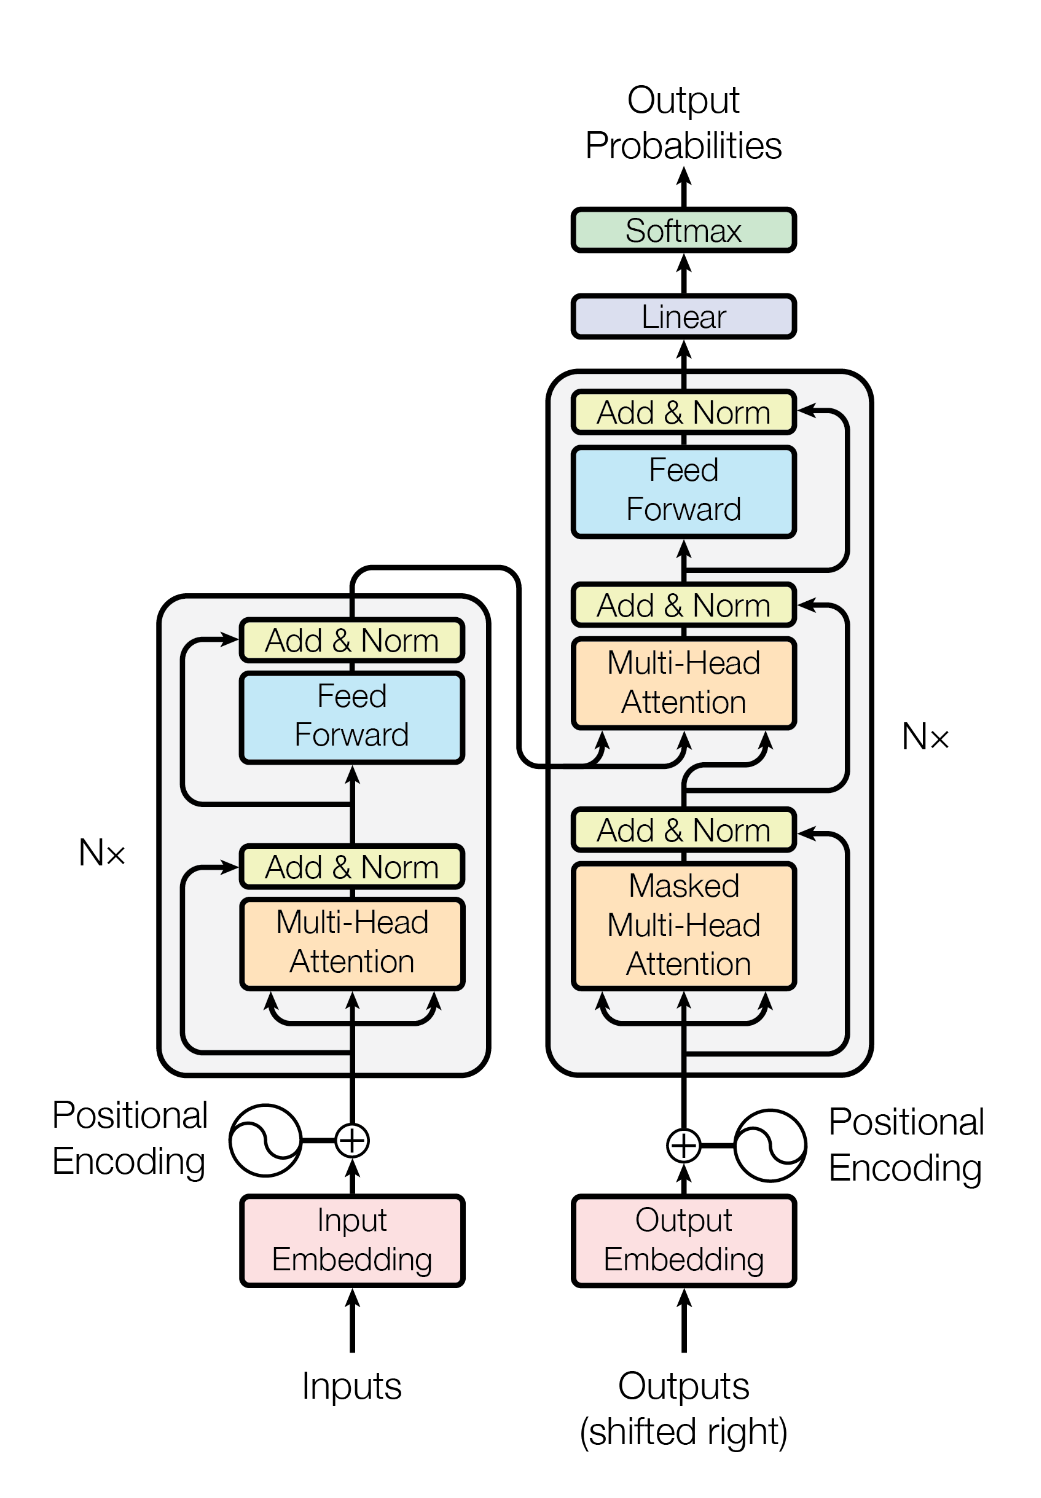

The Transformer follows a typical Encoder/Decoder architecture. It takes an input sequence of symbols $(x_1, ..., x_n)$ and maps this to a sequence of continuous representations $\mathbf{h} = (h_1, ..., h_n)$. Given $h$, the decoder generates a symbol one element at a time $(y_1, ..., y_m)$.

### Encoder
Each encoder layer in the Transformer consists of two sub-layers. The first of these layers is the _Multi-Head Self-Attention_ module, and the second is a module called a _Position-Wise Feed-Forward Network_. Immediately following each one of these modules is a _Residual Layer Normalization_.

### Decoder
A decoder layer is similar to an encoder layer, but it has one extra module inserted: _Masked Multi-Head Attention_. We will discuss the decoder more in a further session. 


At the heart of the Transformer is this concept known as _self-attention_. Let's look at the Transformer holistically and then see exactly what this is, and why and how it solves sequence-to-sequence tasks so effectively.

## The Holistic Transformer

We are attempting to solve a sequence to sequence translation task: German to English using the Transformer:

![whole_transformer](images/transformer.png)

The Transformer is comprised of a stack of encoders and a stack of decoders. The output from the final layer of the encoder stack is sent to the decoder. The input to the first encoder is done via a special embedding module. We will look at the decoder and the embedding module in a future session.

![transformer_high_level](images/transformer_high_level.png)

Within the encoder stack we have a set of connected encoders. The output of one encoder is sent as input to the next encoder. An encoder consists of two sub-layers. The first sub-layer consists of a _Multi-Head Self-Attention_ module, and the second, a _Feed-Forward_ module. Within each module, a _Residual Connection_ followed by a _Layer Normalization_ is immediately applied.

![encoder_first_few](images/encoder_first_few.png)

Let's deconstruct what this new terminology means one by one. We'll start with _self attention_ and _multi-head self-attention_. Then we'll look at _residual connections_ followed by _layer normalization_. After we've covered the _feed-forward_ module, you've managed to understand most of the techniques in the Transformer! The encoder is simply the 6 aformenetioned things.

## Self-Attention

At the heart of the Transformer is self-attention. Self-attention is a mechanism that allows each input in a sequence to look at the whole sequence to compute a representation of the sequence.

$$Attention(Q,K,V) = softmax \left( \frac{QK^T}{\sqrt{d_k}}\right)V$$

...what?

Ok. Let's look at the following sentence: `the animal didn't cross the street because it was too tired`. What does the `it` refer to in this sentence? The street or the animal? This is trivial for us as humans to answer but not for a machine. Wouldn't it be nice if we could have some way of the computer understanding what `it` referred to?

This is what self-attention attempts to do. As the model processes each word in the input sequence, self-attention allows us to look at other words in the input sequence for ideas as to what we want to encode in the representation of this word.

To make this clearer, think of how a hidden state in an RNN incorporates the representation of the previous words into the current representation. Self-attention is how the Transformer attempts to use other words (not just the previous words) to encode the meaning of a particular word


![encoder_multihead](images/encoder_multihead.png)

![vector_attn_score](images/vector_attn_scores.png)

### Self-Attention in detail

Self-attention is a representation which you can think of as a score. The intent is to have a representation, per input word, which tells us much how much focus each word needs to pay to every word in the sequence. A bit complicated right? Hopefully by the end of this post, this meaning will be clear.

Before talking about matrices, let's talk in terms of vectors. We'll have the sequence length be of dimension $T$, and the encoding/embeddings of the word be $D$ dimensional.

Note that because I'm focusing on the FIRST Encoder here, the encodings of our sequence is the embeddings. But as you move up the encoder stack, the encoding of the sequence is the output from the previous encoder. Again, this is $D$ dimensional.

![word_encodings](images/word_encodings.png)


Ok. Now we're going to create three vectors for EACH input: A query vector ($q$), a key vector ($k$), and a value vector ($v$). These will be $d_k$ dimensional. $d_k$ is typically $D/8$. As far as real values go, usually $D=512$, while $d_k=64$. In our example, what is $d_k$?

Ok... so how how do we get $q$, $k$, $v$? We learn it of course!

how... do we learn it? We need a weights matrix which will transform our encodings into these vectors.
This means that $W^Q$, $W^K$ and $W^V$ are all $\in \mathbb{R}^{D×d_k}$

![qkv_vectors](images/qkv_vectors.png)


Ok, that's nice. We understand that $q$, $k$, $v$ are different projections of the same input now; but what do the query, key, value abstractions actually mean? They're useful terms we can use to think about attention. Let's look through the following so we can see the roles they play.

Recall what we defined self-attention as earlier: A representation, per input word, which tells us much how much focus each word needs to pay to every word in the sequence. For each word in our sequence, we will calculate a score by taking the dot product of the current word's query vector and the key vector for every word in the sequence.

![w1_til_softmax](images/w1_til_softmax.png)

Let's take stock of what we've done so far:
- The $÷\sqrt{d_k}$ is simply a practical scaling factor which leads to stabler gradients.
- Softmax turns our scores into a probability distribution (each score is now between 0 and 1, and the sum of the scores = 1).

We will now use these scores by multiplying them with their value vector. The intention here is that lower scoring words will have less weighting in the self-attention output as these words will now have a sense of "irrelevantness" (e.g. a low score like 0.0001 will "cancel out" its corresponding value vector).

![w1_til_z1](images/w1_til_z1.png)

Finally, the output for the current word is the summation of all the $softmax \times v$ vectors. I.e. a weighted sum:

![z_vector](images/z_vector.png)

Ok. So that's self-attention in vector form. What about in terms of matrices?

- Our input, $X$, is now a matrix of our sequence of words (i.e. $X \in \mathbb{R}^{T\times D}$):
![x_matrix](images/X_matrix_input.png)

- $Q$, $K$, $V$ are now also matrices $\in \mathbb{R}^{T \times d_k}$.
- $W^Q$,$W^K$,$W^V$ stay $\in \mathbb{R}^{D \times d_k}$.
- We now simply obtain $Z \in \mathbb{R}^{T \times d_k}$ by plugging $Q$, $K$, $V$ into our Attention formula.

![Z_matrix](images/Z_matrix.png)


- For the FIRST encoder, Q, K, V are determined by the embeddings of the input words
- For the rest of the encoder stack, Q, K, V are determined by the output of the previous encoder
- For the decoder stack, Q is determined in a similar fashion to the encoders. K and V, however, are passed from the final encoder to each of the decoders in the decoder stack.

In [ ]:
# encodings = torch.Tensor([[[0.0, 0.1, 0.2, 0.3], [1.0, 1.1, 1.2, 1.3], [2.0, 2.1, 2.2, 2.3]]]) # (1, 3, 4)
# Q_layer = nn.Linear(4, 3)
# K_layer = nn.Linear(4, 3)
# V_layer = nn.Linear(4, 3)

# Q = Q_layer(encodings)
# K = K_layer(encodings)
# V = V_layer(encodings)

In [ ]:
def scaled_dot_product_attention(Q, K, V, dk=3):
    Q_K_matmul = torch.matmul(Q, K.T)
    matmul_scaled = Q_K_matmul/math.sqrt(dk)
    attention_weights = F.softmax(matmul_scaled, dim=-1)

    output = torch.matmul(attention_weights, V)

    return output, attention_weights

In [ ]:
def print_attention(Q, K, V):
    n_digits = 3
    temp_out, temp_attn = scaled_dot_product_attention(Q, K, V)
    
    print ('Attention weights are:')
    print (np.around(temp_attn, 2))
    print ('Output is:')
    print (np.around(temp_out, 2))


In [ ]:
import torch
import torch.nn.functional as F
import math
import numpy as np

In [ ]:
temp_k = torch.Tensor([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]])  # (4, 3)

temp_v = torch.Tensor([[   1,0, 1],
                      [  10,0, 2],
                      [ 100,5, 0],
                      [1000,6, 0]])  # (4, 3)

In [ ]:
# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = torch.Tensor([[0, 10, 0]])  # (1, 3)
print_attention(temp_q, temp_k, temp_v)

In [ ]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = torch.Tensor([[0, 0, 10]])  # (1, 3)
print_attention(temp_q, temp_k, temp_v)

In [ ]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = torch.Tensor([[10, 10, 0]])  # (1, 3)
print_attention(temp_q, temp_k, temp_v)

In [ ]:
temp_q = torch.Tensor([[0, 0, 10], [0, 10, 0], [10, 10, 0]])  # (3, 3)
print_attention(temp_q, temp_k, temp_v)